In [1]:
import torch 
from torch import nn
import torchvision.transforms as transform
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Conv_layer(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(Conv_layer,self).__init__()
    self.model=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self,x):
    return self.model(x)


In [4]:

from torch.nn.modules.conv import Conv2d
class Unet(nn.Module):
  def __init__(self,in_channels=3,out_channels=1,features=[64,128,256,512]):
    super(Unet,self).__init__()
    self.down_model=nn.ModuleList()
    self.up_model=nn.ModuleList()
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    input_channel=in_channels
    for feature in features:
      self.down_model+=[
                        Conv_layer(input_channel,feature),
                        
      ]
      input_channel=feature
    for feature in reversed(features):
      input_channel=feature
      self.up_model+=[
                      nn.ConvTranspose2d(input_channel*2,feature,kernel_size=2,stride=2),
                      Conv_layer(input_channel*2,feature)
      ]
    
    self.bottle_neck=Conv_layer(features[-1],features[-1]*2)
    self.final_conv=nn.Conv2d(in_channels=features[0],out_channels=out_channels,kernel_size=1)
    self.Sigmoid_=nn.Sigmoid()

  def forward(self,x):
    skip_connections=[]
    for layer in self.down_model:
      x=layer(x)
      skip_connections.append(x)
      x=self.pool(x)
    x=self.bottle_neck(x)
    skip_connections=skip_connections[::-1]
    for idx in range(0,len(self.up_model),2):
      x=self.up_model[idx](x)
      skip_connection=skip_connections[idx//2]
      if x.shape!=skip_connection.shape:
        skip_connection=transform.functional.resize(skip_connection,size=x.shape[2:])
      concate=torch.concat((skip_connection,x),dim=1)
      x=self.up_model[idx+1](concate)

    return self.Sigmoid_(self.final_conv(x))


In [5]:
check_unet=Unet().to(device)

In [6]:
check_unet

Unet(
  (down_model): ModuleList(
    (0): Conv_layer(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): Conv_layer(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): Conv_layer(
 

In [7]:
dataDir='./val2017/val2017/'
dataType='val'
annFile="./annotations_trainval2017/annotations/instances_val2017.json"

# Initialize the COCO api for instance annotations
coco=COCO(annFile)


loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


In [8]:
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

In [9]:
from torchvision.transforms.transforms import Resize
preprocess=transform.Compose([
                              transform.ToTensor(),
                              transform.Resize((240,240)),
                              transform.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
preprocess_mask=transform.Compose([
                              transform.ToTensor(),
                              transform.Resize((240,240))
])

In [10]:
def DataGenerator(batch_size,imgIds):
  total_length=len(imgIds)
  total_batches=total_length//batch_size
  for i in range(total_batches):
    image_list=[]
    mask_list=[]
    start=i*batch_size
    end=start+batch_size
    if end>=total_length:
      end=total_length
    images_info=coco.loadImgs(imgIds[start:end])
    for image_info in images_info:
      file_name='./val2017/val2017/{}'.format(image_info['file_name'])
      Image = cv2.imread(file_name)
      Image=cv2.cvtColor(Image,cv2.COLOR_BGR2RGB)
      # print("max image: ",np.amax(Image))
      # print("min image: ",np.amin(Image))
      Image=preprocess(Image)
      
      image_list.append(Image)
      annIds = coco.getAnnIds(imgIds=image_info['id'], catIds=catIds, iscrowd=None)
      anns = coco.loadAnns(annIds)
      mask = np.zeros((image_info['height'],image_info['width']))
      for i in range(len(anns)):
          mask = np.maximum(coco.annToMask(anns[i]), mask)
      mask=preprocess_mask(mask)
      mask_list.append(mask)
    yield torch.stack(image_list),torch.stack(mask_list)

torch.Size([3, 240, 240])
{'segmentation': [[77.25, 401.24, 50.18, 410.01, 44.33, 401.97, 65.54, 387.34, 67.74, 357.35, 70.67, 351.5, 111.63, 351.5, 112.36, 339.06, 98.46, 335.4, 91.88, 336.87, 85.29, 334.67, 47.26, 347.84, 39.94, 356.62, 42.87, 361.01, 33.36, 359.54, 33.36, 352.23, 46.53, 341.26, 93.34, 317.12, 97.0, 300.29, 105.78, 292.25, 116.75, 290.05, 123.33, 298.1, 125.53, 307.61, 125.53, 312.73, 131.38, 320.04, 135.77, 338.33, 131.38, 356.62, 129.18, 367.59, 106.51, 393.19, 103.58, 405.63, 91.15, 394.65, 121.87, 360.27, 103.58, 372.71, 79.44, 366.86, 77.25, 391.73, 78.71, 399.77]], 'area': 4683.614549999998, 'iscrowd': 0, 'image_id': 274460, 'bbox': [33.36, 290.05, 102.41, 119.96], 'category_id': 1, 'id': 1276518}


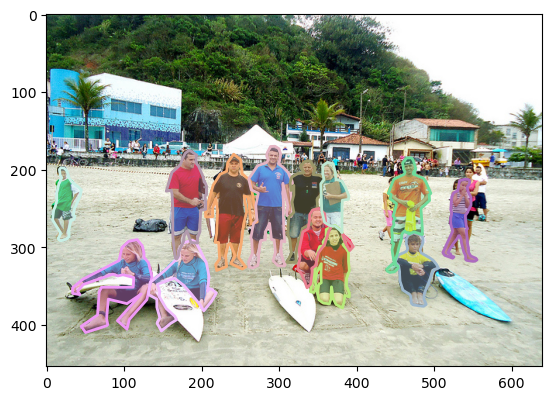

In [11]:
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
file_name='./val2017/val2017/{}'.format(img['file_name'])
Image = cv2.imread(file_name)
Image=cv2.cvtColor(Image,cv2.COLOR_BGR2RGB)
print((preprocess(Image)).shape)
plt.imshow(Image)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print((anns[0]))
coco.showAnns(anns)

In [12]:
num_epochs=5
lr=0.0001
batch_size=20
optimizer=torch.optim.SGD(check_unet.parameters(),lr=lr)
criterion=torch.nn.BCELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


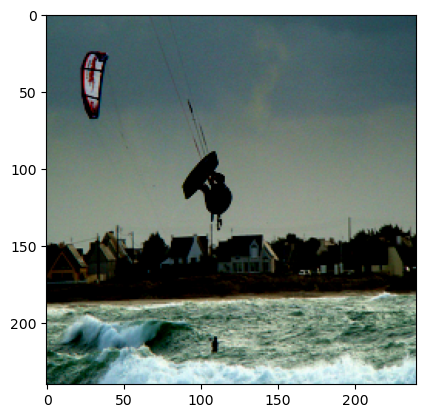

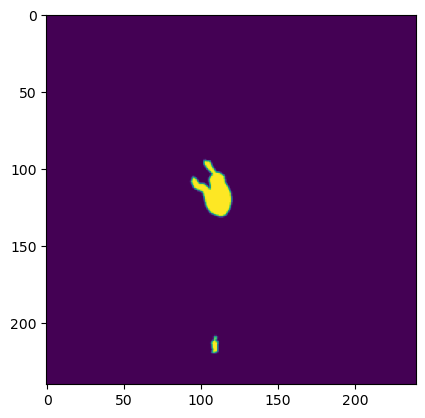

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


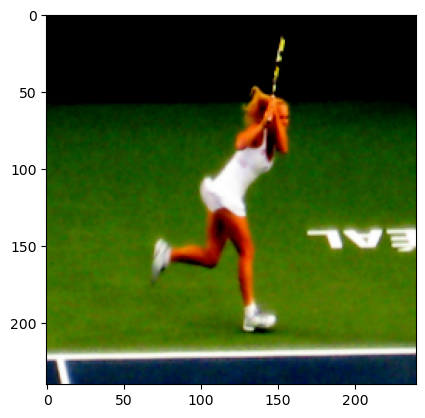

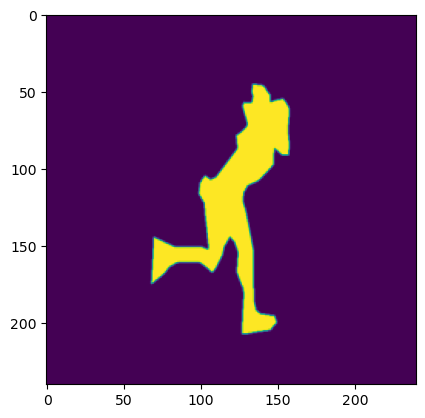

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


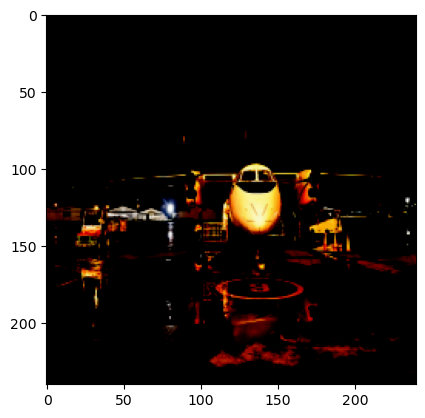

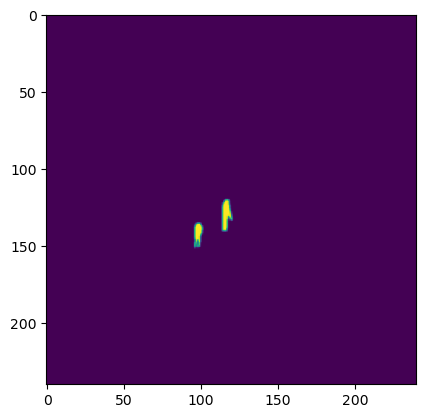

In [13]:
for epochs in range(num_epochs):
  check_image=np.empty(shape=(240,240,3))
  check_here=epochs
  for idx,(image,labels) in enumerate(DataGenerator(batch_size,imgIds)):
    check_image[:,:,0]=image[check_here,0,:,:]
    check_image[:,:,1]=image[check_here,1,:,:]
    check_image[:,:,2]=image[check_here,2,:,:]
    plt.imshow(check_image)
    plt.show()
    plt.imshow((labels[check_here,0,:,:]).numpy())
    plt.show()
    if idx >= 3:
      break

    # image=image.to(device)
    # labels=labels.float().to(device)
    # output=check_unet(image)
    # losses=criterion(output,labels)
    # check_unet.zero_grad()
    # losses.backward()
    # optimizer.step()
    # if (idx+1)%50==0:
    #   print("epochs",epochs, "iteration",idx,"loss",losses.item())
    #   dice_score=(2*(output*labels).sum())/((output+labels).sum()+1e-8)
    #   print("dice score",dice_score)